Loaded 8 joints, 6000 frames
Frame time: 0.042s


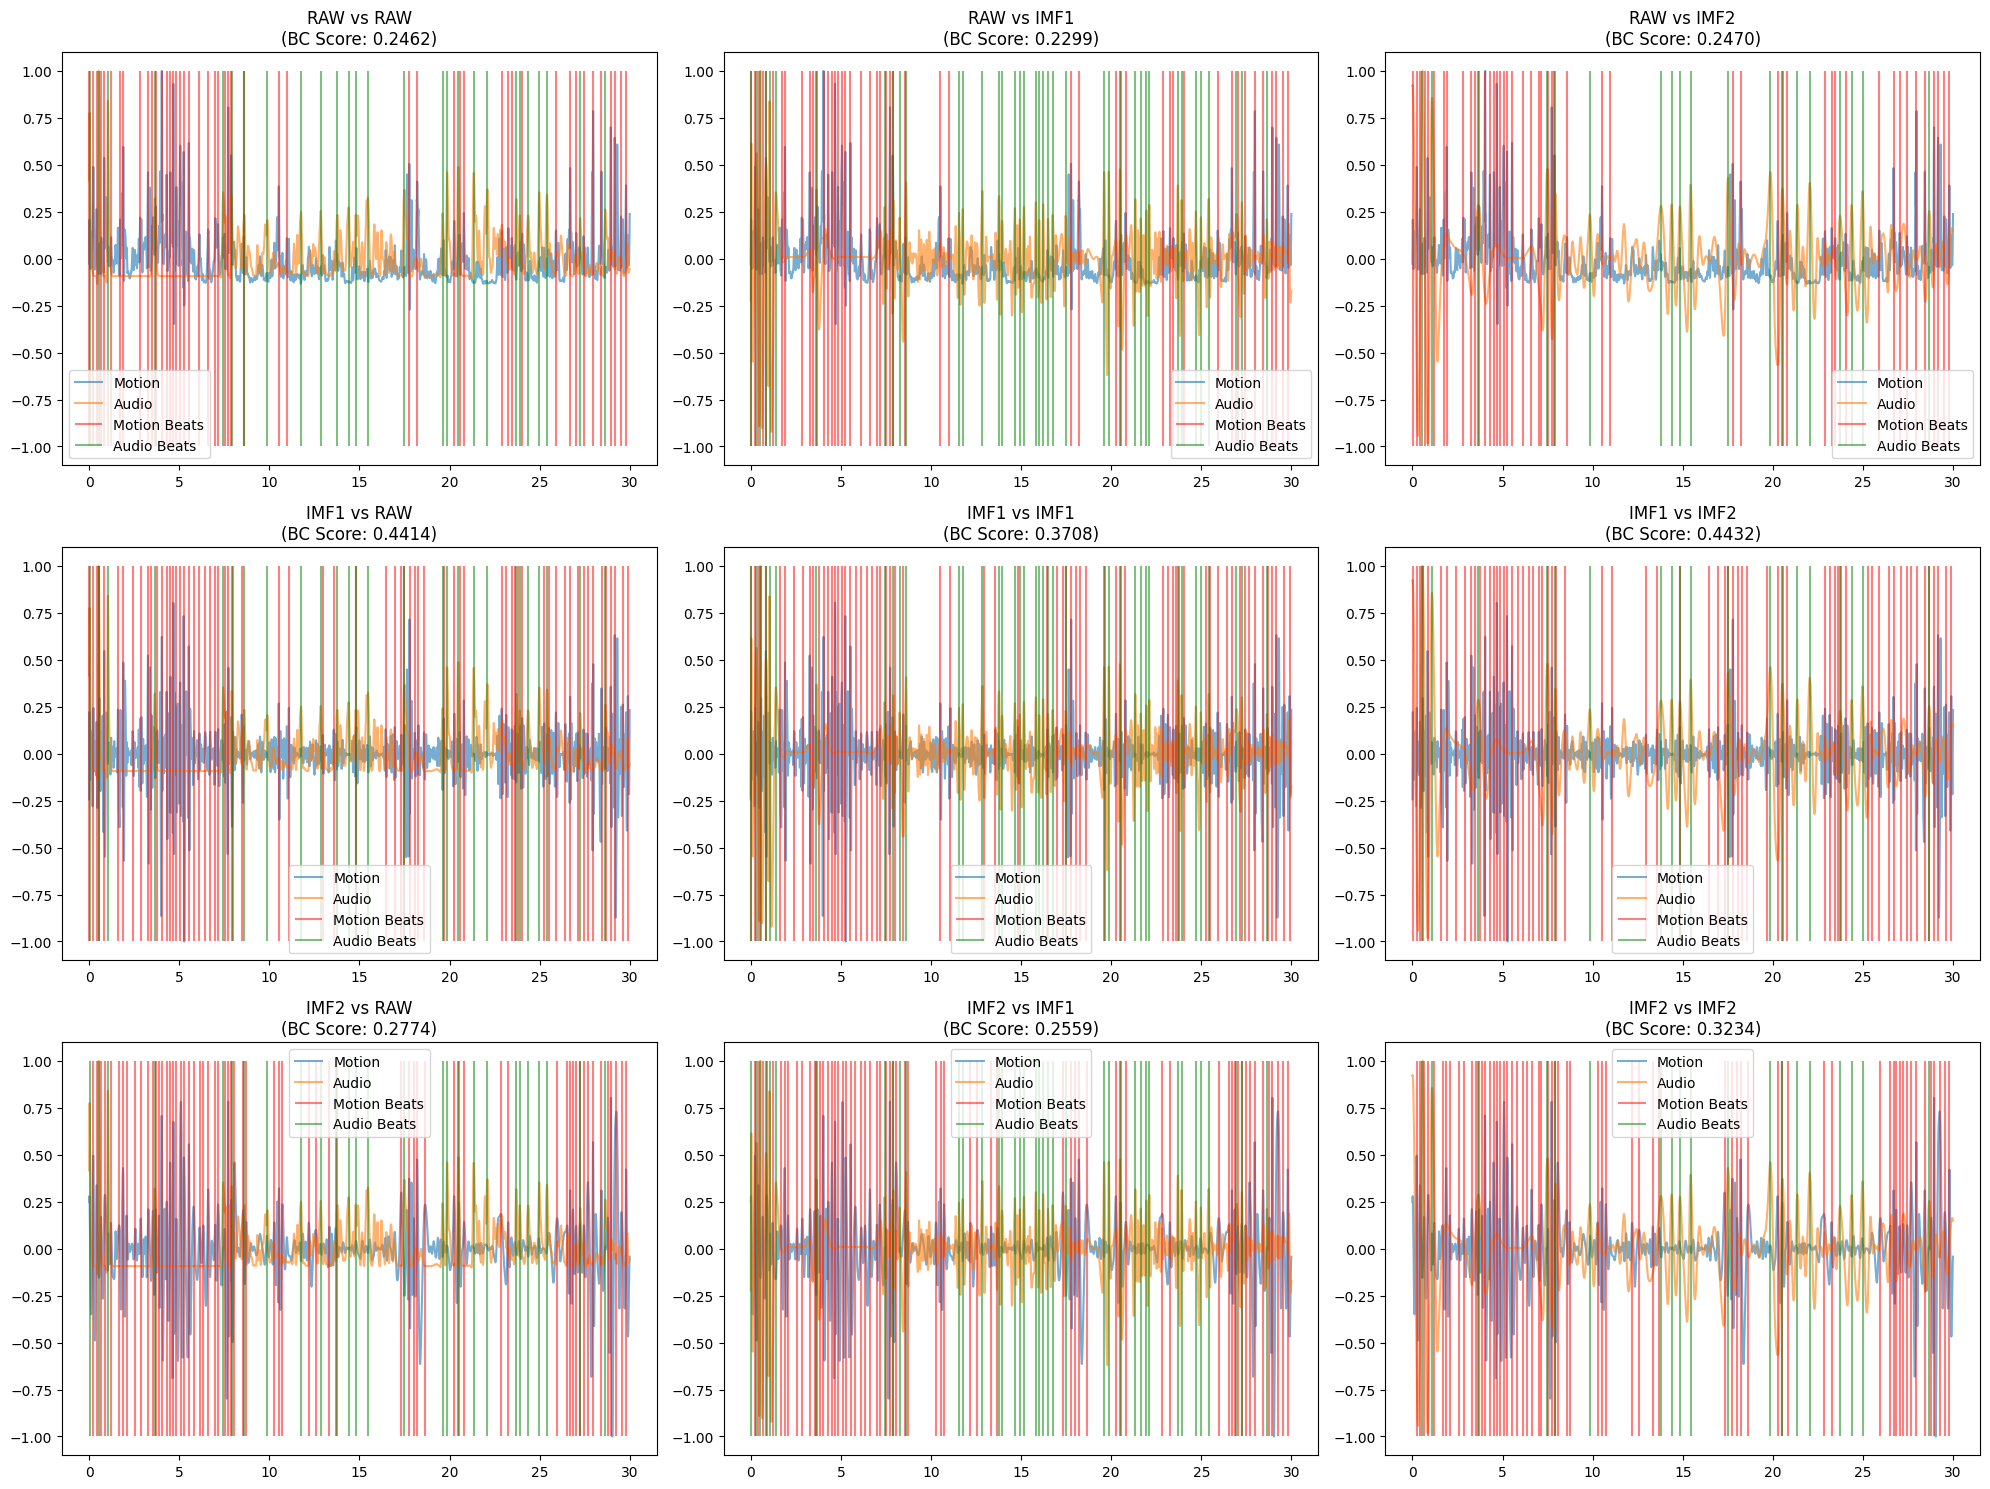


Beat Consistency Scores:
----------------------------------------
Signal Pair               Score
----------------------------------------
raw_vs_raw               0.2462
raw_vs_imf1              0.2299
raw_vs_imf2              0.2470
imf1_vs_raw              0.4414
imf1_vs_imf1             0.3708
imf1_vs_imf2             0.4432
imf2_vs_raw              0.2774
imf2_vs_imf1             0.2559
imf2_vs_imf2             0.3234
----------------------------------------


In [7]:
"""BEat Consistency metric using Empirical Mode Decomposition (BECEMD)""" 
import numpy as np
import scipy.signal
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter
import librosa
import emd
import copy
from sklearn.linear_model import LinearRegression
from bvh import Bvh
import matplotlib.pyplot as plt
import glob

samples = "../samples/"

audios = glob.glob(samples + "*.wav")
motions = glob.glob(samples + "*.npz")


# Your existing filter and envelope functions
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def amp_envelope(audiofilename):
    audio, sr = librosa.load(audiofilename, sr=None)
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

def my_get_next_imf(x, zoom=None, sd_thresh=0.1):
    proto_imf = x.copy()
    continue_sift = True
    niters = 0

    if zoom is None:
        zoom = (0, x.shape[0])

    while continue_sift:
        niters += 1
        upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
        lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')
        avg_env = (upper_env+lower_env) / 2
        stop, val = emd.sift.stop_imf_sd(proto_imf-avg_env, proto_imf, sd=sd_thresh)
        proto_imf = proto_imf - avg_env
        if stop:
            continue_sift = False

    return proto_imf

def detect_motion_beats(signal, threshold=0.1, min_distance=30, fps=200):
    """
    Detect motion beats using find_peaks with adjusted parameters
    """
    peaks, _ = find_peaks(signal, 
                         height=threshold,
                         distance=min_distance,  # Minimum samples between peaks
                         prominence=threshold)   # Minimum prominence of peaks
    
    return peaks / fps

def beat_consistency_score(motion_beats, signal, sr=200, sigma=0.1):
    """
    Compute Beat Consistency Score between motion and audio beats
    """
    if len(motion_beats) == 0:
        return 0.0, []
    
    # Find peaks in signal
    peaks, _ = find_peaks(signal, 
                         height=0.2,
                         distance=30,
                         prominence=0.2)
    
    signal_beats = peaks / sr
    
    if len(signal_beats) == 0:
        return 0.0, []
    
    total_score = 0
    for audio_time in signal_beats:
        min_dist = np.min((audio_time - motion_beats) ** 2)
        score = np.exp(-min_dist / (2 * sigma * sigma))
        total_score += score
    
    return total_score / len(signal_beats), signal_beats

def calculate_angle_changes(angles_data, change_angle_weights=None):
    angle_pairs = [
        ('LeftArm', 'LeftForeArm'),
        ('RightArm', 'RightForeArm'),
        ('LeftForeArm', 'LeftHand'),
        ('RightForeArm', 'RightHand')
    ]
    
    if change_angle_weights is None:
        change_angle_weights = [1.0] * len(angle_pairs)
    
    n_frames = len(next(iter(angles_data.values())))
    angle_diff = np.zeros(n_frames)
    
    for idx, (joint1, joint2) in enumerate(angle_pairs):
        # Get vectors and apply Savgol filter to smooth angles
        vec1 = savgol_filter(angles_data[joint1], window_length=31, polyorder=3, axis=0)
        vec2 = savgol_filter(angles_data[joint2], window_length=31, polyorder=3, axis=0)
        
        # Normalize vectors
        vec1_norm = vec1 / np.linalg.norm(vec1, axis=1)[:, np.newaxis]
        vec2_norm = vec2 / np.linalg.norm(vec2, axis=1)[:, np.newaxis]
        
        # Calculate angles
        inner_product = np.sum(vec1_norm * vec2_norm, axis=1)
        inner_product = np.clip(inner_product, -1, 1)
        angles = np.arccos(inner_product) / np.pi
        
        # Calculate derivatives and apply Savgol filter again
        angle_changes = np.abs(np.diff(angles))
        angle_changes = np.concatenate(([0], angle_changes))
        angle_changes = savgol_filter(angle_changes, window_length=15, polyorder=3)
        
        angle_diff += angle_changes / change_angle_weights[idx] / len(change_angle_weights)
    
    return angle_diff

def extract_arm_angles(filename):
    with open(filename) as f:
        mocap = Bvh(f.read())
    
    arm_joints = [
        'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand',
        'RightShoulder', 'RightArm', 'RightForeArm', 'RightHand'
    ]
    
    angles = {}
    for joint in arm_joints:
        if joint in mocap.get_joints_names():
            channels = mocap.joint_channels(joint)
            data = []
            for frame in range(mocap.nframes):
                frame_data = []
                for channel in channels:
                    if 'rotation' in channel:
                        frame_data.append(mocap.frame_joint_channel(frame, joint, channel))
                data.append(frame_data)
            angles[joint] = np.array(data)
    
    frame_time = mocap.frame_time
    print(f"Loaded {len(angles)} joints, {len(next(iter(angles.values())))} frames")
    print(f"Frame time: {frame_time:.3f}s")
    
    return angles, frame_time

def scale_signal(signal):
    """
    Scale signal to range [-1, 1] around zero mean
    """
    # Remove mean
    signal = signal - np.mean(signal)
    # Scale to [-1, 1]
    if np.max(np.abs(signal)) > 0:  # Avoid division by zero
        signal = signal / np.max(np.abs(signal))
    return signal


def compute_all_beat_consistency(bvh_file, audio_file, plot=True):
    """
    Compute Beat Consistency scores between all combinations of signals
    """
    # Load and process data
    angles, frame_time = extract_arm_angles(bvh_file)
    angle_diff = calculate_angle_changes(angles)
    angle_diff = scale_signal(angle_diff)
    
    # Process audio
    ampv, sr = amp_envelope(audio_file)
    target_len = len(angle_diff)
    ampv = np.interp(np.linspace(0, len(ampv), target_len), 
                     np.arange(len(ampv)), 
                     ampv)
    ampv = scale_signal(ampv)

    # Calculate IMFs
    motion_signals = {
        'raw': angle_diff,
        'imf1': scale_signal(my_get_next_imf(angle_diff)),
        'imf2': scale_signal(my_get_next_imf(angle_diff - my_get_next_imf(angle_diff)))
    }
    
    audio_signals = {
        'raw': ampv,
        'imf1': scale_signal(my_get_next_imf(ampv)),
        'imf2': scale_signal(my_get_next_imf(ampv - my_get_next_imf(ampv)))
    }

    # Calculate beats for each motion signal
    motion_beats = {}
    for name, signal in motion_signals.items():
        beats = detect_motion_beats(signal, threshold=0.1, min_distance=30)
        motion_beats[name] = beats

    # Calculate cross-signal beat consistency
    scores = {}
    beats = {}
    for m_name, m_beats in motion_beats.items():
        for a_name, a_signal in audio_signals.items():
            key = f"{m_name}_vs_{a_name}"
            score, beat_times = beat_consistency_score(m_beats, a_signal)
            scores[key] = score
            beats[key] = beat_times

    if plot:
        # Create a larger figure for all combinations
        plt.figure(figsize=(20, 15))
        n_plots = len(motion_signals) * len(audio_signals)
        n_rows = len(motion_signals)
        n_cols = len(audio_signals)
        
        for i, (m_name, m_signal) in enumerate(motion_signals.items()):
            for j, (a_name, a_signal) in enumerate(audio_signals.items()):
                plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
                time_axis = np.arange(len(m_signal)) / 200
                
                plt.plot(time_axis, m_signal, label='Motion', alpha=0.6)
                plt.plot(time_axis, a_signal, label='Audio', alpha=0.6)
                
                key = f"{m_name}_vs_{a_name}"
                plt.vlines(motion_beats[m_name], -1, 1, colors='r', 
                         label='Motion Beats', alpha=0.5)
                plt.vlines(beats[key], -1, 1, colors='g', 
                         label='Audio Beats', alpha=0.5)
                
                plt.title(f'{m_name.upper()} vs {a_name.upper()}\n(BC Score: {scores[key]:.4f})')
                plt.ylim(-1.1, 1.1)
                plt.legend()

        plt.tight_layout()
        plt.show()

    return scores, beats

# Main execution
if __name__ == "__main__":
    bvh_file = '../samples/c-cut.bvh'
    audio_file = audios[0]
    
    # Compute all beat consistency scores and get the results
    scores, beats = compute_all_beat_consistency(bvh_file, audio_file, plot=True)
    
    # Print all scores in a formatted table
    print("\nBeat Consistency Scores:")
    print("-" * 40)
    print(f"{'Signal Pair':<20} {'Score':>10}")
    print("-" * 40)
    for key, score in scores.items():
        print(f"{key:<20} {score:>10.4f}")
    print("-" * 40)